In [22]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
from torchsummary import summary
import torch.nn.functional as F

# library to get dataloader
from dataloaders import get_pkmn_dataloader

# library to get loss functions
from loss_functions import get_generator_loss_func,get_disc_loss_func,gradient_penalty,get_gradient

# generators and discriminators
from DCGeneratorCustom import DCGeneratorCustom
from DCDiscriminatorCustom import DCDiscriminatorCustom
from DCGeneratorStandard import DCGeneratorStandard
from DCDiscriminatorStandard import DCDiscriminatorStandard
from DCDiscriminatorStandardDropout import DCDiscriminatorStandardDropout
from DiscriminatorPatchGAN import DiscriminatorPatchGAN

from DCGeneratorConditional import DCGeneratorConditional
from DCDiscriminatorConditional import DCDiscriminatorConditional
from UNetArchitecture import UNet


# for classification analysis
from MultiClassConvNetStandardDropout import MultiClassConvNetStandardDropout

# util methods
from utils import get_noise

# constants
from pkmn_constants import PKMN_TYPES,CLASS_IDX_2_PKMN_TYPE,NUM_PKMN_TYPES

# whether to use CPU/GPU (pass this along everywhere)
device_str = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_str)

print("Using device: {}".format(device_str))

Using device: cpu


In [2]:
print(torch.__version__)

# if apply_denormalization is true, then we re-scale the images back 
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), denorm_transform = None, use_uniform_transform = False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    
    # We don't specifically need this since we are doing the denormalization ourself
    
    if denorm_transform is not None:
      assert use_uniform_transform == False
      image_tensor = denorm_transform(image_tensor)
    if use_uniform_transform:
      # cannot use both uniform and denorm transform together
      assert denorm_transform == None
      image_tensor = (image_tensor + 1) / 2 # scale from [-1, 1] to [0, 1] space
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def save_model(model, output_filename):
  torch.save(model.state_dict(), output_filename)

1.10.2


In [3]:
# testing if we can create and summarize the Unet
# Input is (bs, z_dim)
# output is (3, 96, 96) image (difficult to change this!)

# How would we extend this to a conditional input ?


test_classification_model = MultiClassConvNetStandardDropout(num_classes = NUM_PKMN_TYPES)

summary(test_classification_model, [(3, 64, 64)], device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
         Dropout2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]         131,200
       BatchNorm2d-6          [-1, 128, 16, 16]             256
         LeakyReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8            [-1, 256, 8, 8]         524,544
       BatchNorm2d-9            [-1, 256, 8, 8]             512
        LeakyReLU-10            [-1, 256, 8, 8]               0
        Dropout2d-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 512, 4, 4]       2,097,664
      BatchNorm2d-13            [-1, 512, 4, 4]           1,024
        LeakyReLU-14            [-1, 51

In [31]:
# ======= Define the basic hyper-parameters =====


# training epochs
n_epochs = 10

# hidden dimensions
hidden_dim = 32
batch_size = 64

num_classes = NUM_PKMN_TYPES # todo: change this if using different problem formulations

periodic_saving = False
# after how many epochs do you save the model?
epoch_save_step = 5
save_prefix = "Pokemon_Discriminator_DC_firstTest"

lr = 1e-3
beta_1 = 0.5
beta_2 = 0.999

# how often to display chart
display_step = 100


# loss functions
use_wgan_loss = False
loss_func = nn.CrossEntropyLoss()

assert imgs_to_display <= batch_size

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


length of dataset (number of steps) is: 167, total size is: 10688


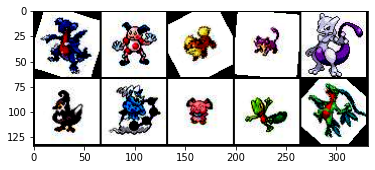

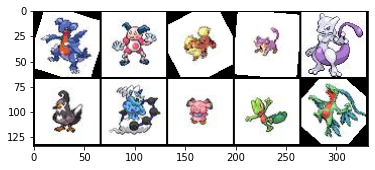

In [32]:
# Create the dataloader, based on the appropriate batch size. 

show_preview = True
dataloader_name = "conditional_64_dim_no_shiny_with_flip_and_rotate_and_standard_norm"
pkmn_dataloader, denorm_transform = get_pkmn_dataloader(dataloader_name, batch_size)
test_size = 10

# show a batch before and after denorm
test_data_iter = iter(pkmn_dataloader)
test_images, test_labels = next(test_data_iter)

print("length of dataset (number of steps) is: {}, total size is: {}".format(len(pkmn_dataloader), len(pkmn_dataloader)*batch_size))

if show_preview:
  show_tensor_images(test_images[0:test_size], num_images = test_size, size = (3,64,64), denorm_transform = None)
  show_tensor_images(test_images[0:test_size], num_images = test_size, size = (3,64,64), denorm_transform = denorm_transform)

# todo: create train/test split right here

val_pct = 0.10

# TODO: Fix this !!!!!
# this doesnt' play nicely. Basically, a dataloader comes AFTER a dataset, so we need to split before this.
#train_set, val_set = torch.utils.data.random_split(pkmn_dataloader, [150, 17])

In [33]:
# Create the generator/discriminator and use them
# layer initialization for Generator and Discriminator (for Conv2d and ConvTranpose2d)

model = MultiClassConvNetStandardDropout(num_classes = num_classes, hidden_dim = hidden_dim).to(device) 
model_opt = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta_1, beta_2))

print("Initializing the model with {} classes!".format(num_classes))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
model = model.apply(weights_init)


Initializing the model with 18 classes!


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/167 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 100: Epoch: 0: loss: 2.796854019165039 acc: 0.118125


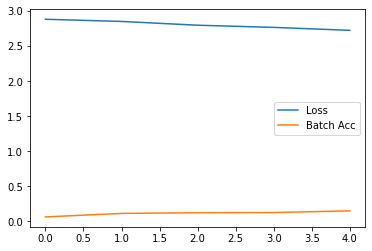

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/167 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 200: Epoch: 1: loss: 2.6816561222076416 acc: 0.15528124999999998


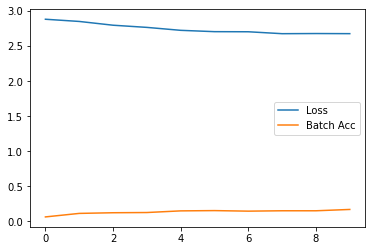

Step 300: Epoch: 1: loss: 2.6086928844451904 acc: 0.19609375


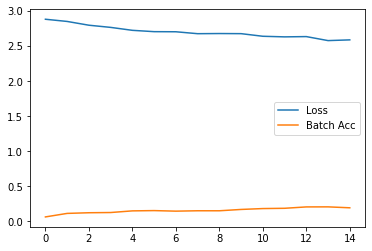

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/167 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Step 400: Epoch: 2: loss: 2.5080106258392334 acc: 0.2396875


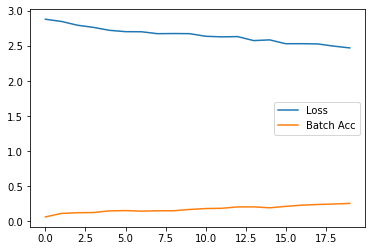

Step 500: Epoch: 2: loss: 2.439072370529175 acc: 0.26096875


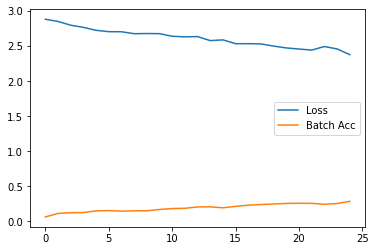

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


  0%|          | 0/167 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


KeyboardInterrupt: 

In [34]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

cur_step = 0
losses = []
batch_accs = []

for epoch in range(n_epochs):
    # Dataloader returns the (real_images, labels)
    for real, true_labels in tqdm(pkmn_dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        true_labels = true_labels.to(device)
        
        # zero out optimizer
        model_opt.zero_grad()
        
        # get the predictions. Shape (bs, num_classes)
        model_logits = model(real)
                
        model_preds = torch.argmax(model_logits, dim = 1)
        
        # y_true, y_pred
        model_acc = accuracy_score(true_labels, model_preds)
        batch_accs.append(model_acc)
        
        # compute the loss on a batch
        ce_loss = loss_func(model_logits, true_labels)
        
        # record loss for graphing purposes
        losses.append(ce_loss)
        
        # backprop
        ce_loss.backward()
        
        # update optimizer
        model_opt.step()
        
        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            mean_loss = sum(losses[-display_step:]) / display_step
            mean_acc = sum(batch_accs[-display_step:]) / display_step
            print(f"Step {cur_step}: Epoch: {epoch}: loss: {mean_loss} acc: {mean_acc}")
            step_bins = 20
            
            num_examples = (len(losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(batch_accs[:num_examples]).view(-1, step_bins).mean(1),
                label="Batch Acc"
            )            
            plt.legend()
            plt.show()
        
        # increase the current step (ie. one batch)
        cur_step += 1
        
    if periodic_saving and epoch % epoch_save_step == 0:
      outfile_name = "{}_{}.pt".format(save_prefix, cur_step)
      print("===== Saving intermediate model with name {} ! ====".format(outfile_name))
      save_model(gen, outfile_name)

In [ ]:
# Save the final model

out_file = "second_gan_with_standard_dcgan_arch_after_149epochs.pt"
  
save_model(gen, out_file)

In [ ]:
# Load model for inference and generate some random classes

gen.load_state_dict(torch.load("{}".format(out_file)))

# Performing inference - actually, maybe I ran some other cell after this so it's not really well defined
num_samples = 10

sample_vector = get_noise(num_samples, z_dim, device)
random_classes = torch.randint(low = 0, high = NUM_PKMN_TYPES, size = (num_samples,)).to(device)

fake_images = gen(sample_vector, random_classes)

output_size = gen.output_dim
# + 0.9
show_tensor_images(fake_images, num_images=num_samples, size=(1,256, 256), use_uniform_transform = True, denorm_transform = None)


pkmn_classes = [CLASS_IDX_2_PKMN_TYPE[class_idx] for class_idx in random_classes.cpu().numpy()]
print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(pkmn_classes[0:5], pkmn_classes[5:]))

In [ ]:
# Generate samples of a specific type from the model
target_type = "Fire"
class_idx = PKMN_TYPES.index(target_type)

class_tiled = torch.from_numpy(np.array([class_idx] * num_samples))

sample_vector = get_noise(num_samples, z_dim, device)
classes = class_tiled.to(device)

fake_images = gen(sample_vector, classes)

output_size = gen.output_dim
# + 0.9
show_tensor_images(fake_images, num_images=num_samples, size=(1,256, 256), use_uniform_transform = True, denorm_transform = None)


pkmn_classes = [CLASS_IDX_2_PKMN_TYPE[class_idx] for class_idx in classes.cpu().numpy()]
print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(pkmn_classes[0:5], pkmn_classes[5:]))
